# GMM example for dynamics data

In [1]:
import sys
sys.path.append('lib')

import numpy as np
import scipy.linalg as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import mixture
from gmr import *
from plot_utils import *

Problem parameters.

## Initialization

In [2]:
nb_dim_in = 2
nb_dim_out = 1
KGMM = 8 # GMM states
#N = 100 # number of test points

sys

In [3]:
from scipy.io import loadmat # loading data from matlab

handover_data = loadmat('data/data_dyn.mat')
trq_in = handover_data['trq_in']
acc_out = handover_data['acc_out']
angle_out = handover_data['angle_out']
demos = np.concatenate((trq_in,angle_out,acc_out),axis=1)
D = demos.shape[1]
print(D)
# This dataset already comes with a time index
# Concatenate
data = np.array(demos)

3


Plot data with respect to time.

In [4]:
data.shape

(10001, 3)

Text(0, 0.5, 'angle_out')

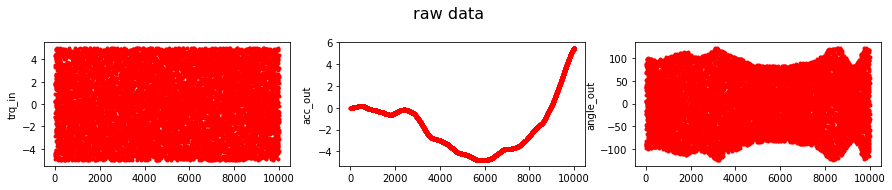

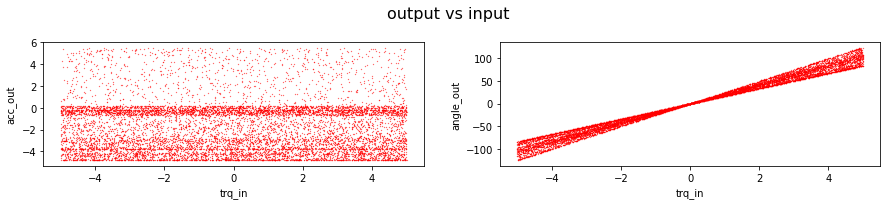

In [5]:
labels = ['trq_in','acc_out','angle_out']
fig1 = plt.figure(figsize=(15,5))
fig1.suptitle('raw data', fontsize=16)

for i in range(D):
    ax = fig1.add_subplot(2,3,i+1)
    plt.plot(data[:,i],'r.',)
    ax.set_ylabel(labels[i])
    
fig2 = plt.figure(figsize=(15,5))
fig2.suptitle('output vs input', fontsize=16)
ax = fig2.add_subplot(2,2,1)
plt.plot(data[:,0],data[:,1],'r.',markersize=0.5)
ax.set_xlabel(labels[0])
ax.set_ylabel(labels[1])
ax = fig2.add_subplot(2,2,2)
plt.plot(data[:,0],data[:,2],'r.',markersize=0.5)
ax.set_xlabel(labels[0])
ax.set_ylabel(labels[2])

Plot data in 3D.

In [6]:
%matplotlib notebook

<IPython.core.display.Javascript object>


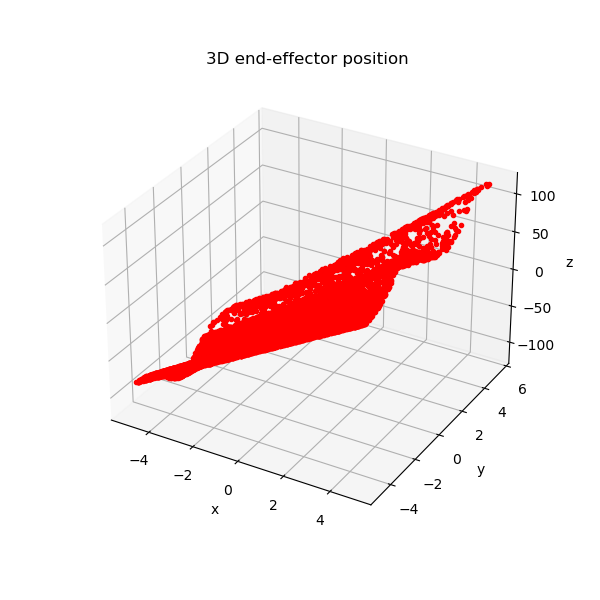

In [7]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(data[:,0],data[:,1],data[:,2],'r.')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('3D end-effector position');

## GMM/GMR

In [8]:
# Train GMM on demonstration data
gmm = mixture.GaussianMixture(n_components=KGMM,covariance_type='full',reg_covar=1E-5,init_params='kmeans')
gmm.fit(data)

GaussianMixture(n_components=8, reg_covar=1e-05)

Show the GMM.

<IPython.core.display.Javascript object>


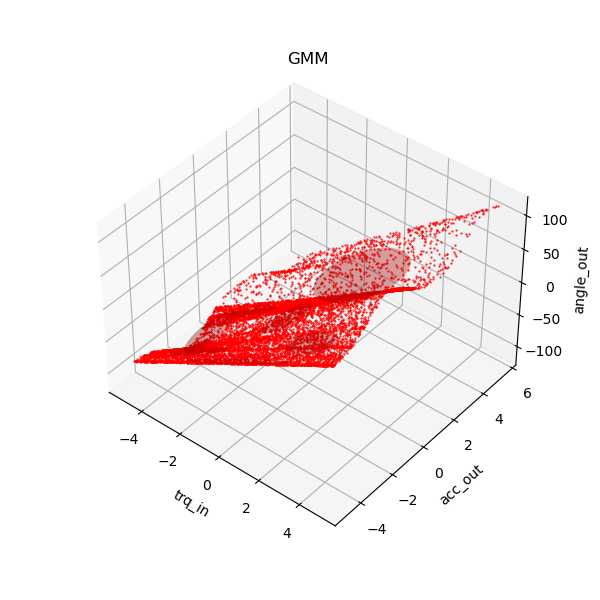

In [9]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
plot_gmm_3d(gmm.covariances_[:,:3,:3],gmm.means_[:,:3],ax,color='r')
ax.plot(data[:,0],data[:,1],data[:,2],'r.',markersize=1.0)
ax.set_xlabel(labels[0])
ax.set_ylabel(labels[1])
ax.set_zlabel(labels[2])
ax.set_title('GMM');

In [51]:
# GMR
d_in = range(0,nb_dim_in)
d_out = range(nb_dim_in,nb_dim_in+nb_dim_out)

In [53]:
# sample the inputs from the marginal distribution
#x_in = np.zeros((N, nb_dim_in)) #original from Joao
x_in = np.concatenate((trq_in,angle_out),axis=1)

#for i in range(0, N):
#    state = np.random.choice(np.arange(0, KGMM), p=gmm.weights_)
#    x_in[i, :] = np.random.multivariate_normal(gmm.means_[state, 0:nb_dim_in], gmm.covariances_[state, 0:nb_dim_in, 0:nb_dim_in])

mu, sigma = gmr(gmm, x_in.T, d_in, d_out, N)

10001


<IPython.core.display.Javascript object>


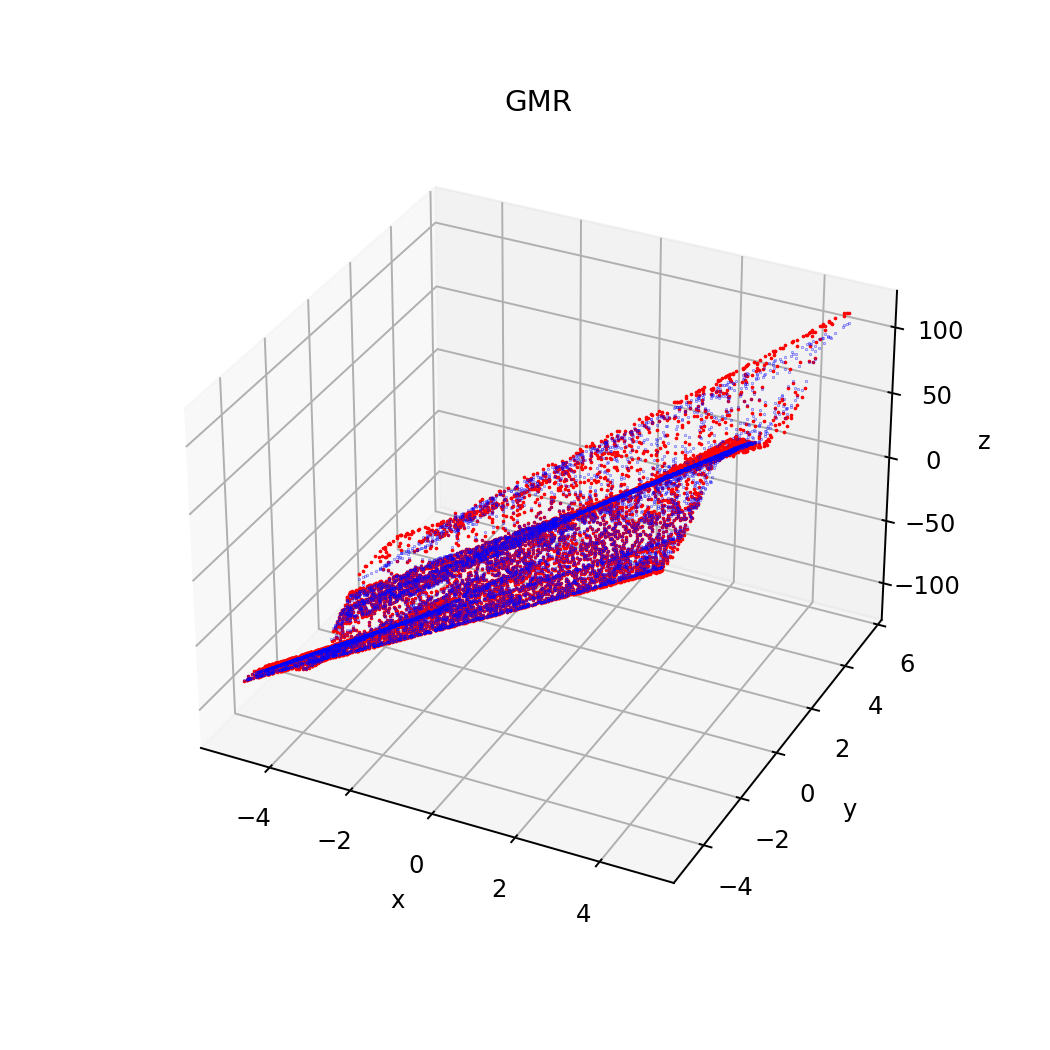

In [57]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(data[:,0],data[:,1],data[:,2],'r.',markersize=1.0)
ax.plot(x_in[:,0],x_in[:,1],mu[:,0],'b.',markersize=.3)
ax.set_xlabel('torque')
ax.set_ylabel('angle')
ax.set_zlabel('acceleration')
ax.set_title('GMR');

<IPython.core.display.Javascript object>


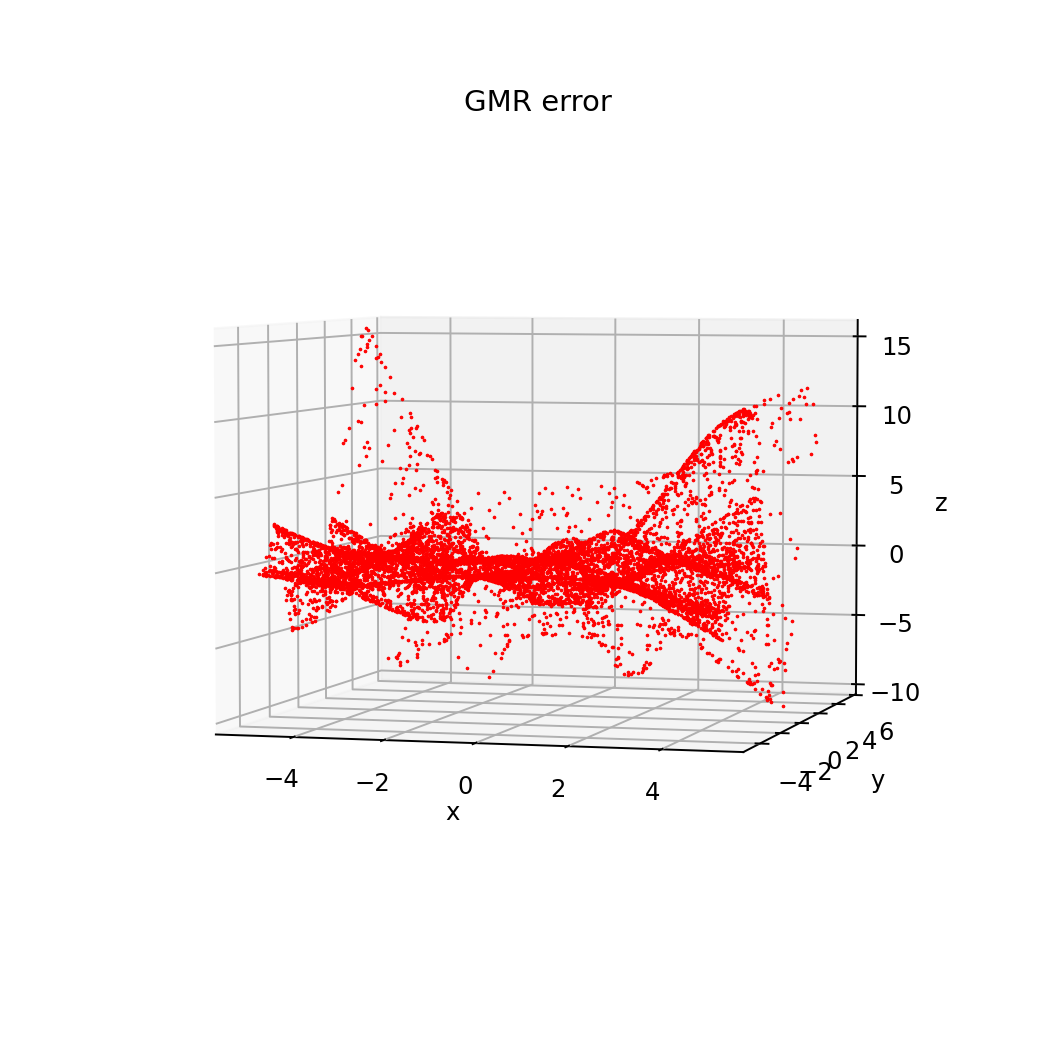

In [58]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(data[:,0],data[:,1],data[:,2]-mu[:,0],'r.',markersize=1.0)
#ax.plot(x_in[:,0],x_in[:,1],mu[:,0],'b.',markersize=.3)
ax.set_xlabel('torque')
ax.set_ylabel('angle')
ax.set_zlabel('acceleration')
ax.set_title('GMR error');

Accuracy is not good enough. So increased the GMM states from 8 to 20

In [59]:
KGMM = 20 # GMM states
gmm = mixture.GaussianMixture(n_components=KGMM,covariance_type='full',reg_covar=1E-5,init_params='kmeans')
gmm.fit(data)
mu, sigma = gmr(gmm, x_in.T, d_in, d_out, N)

<IPython.core.display.Javascript object>


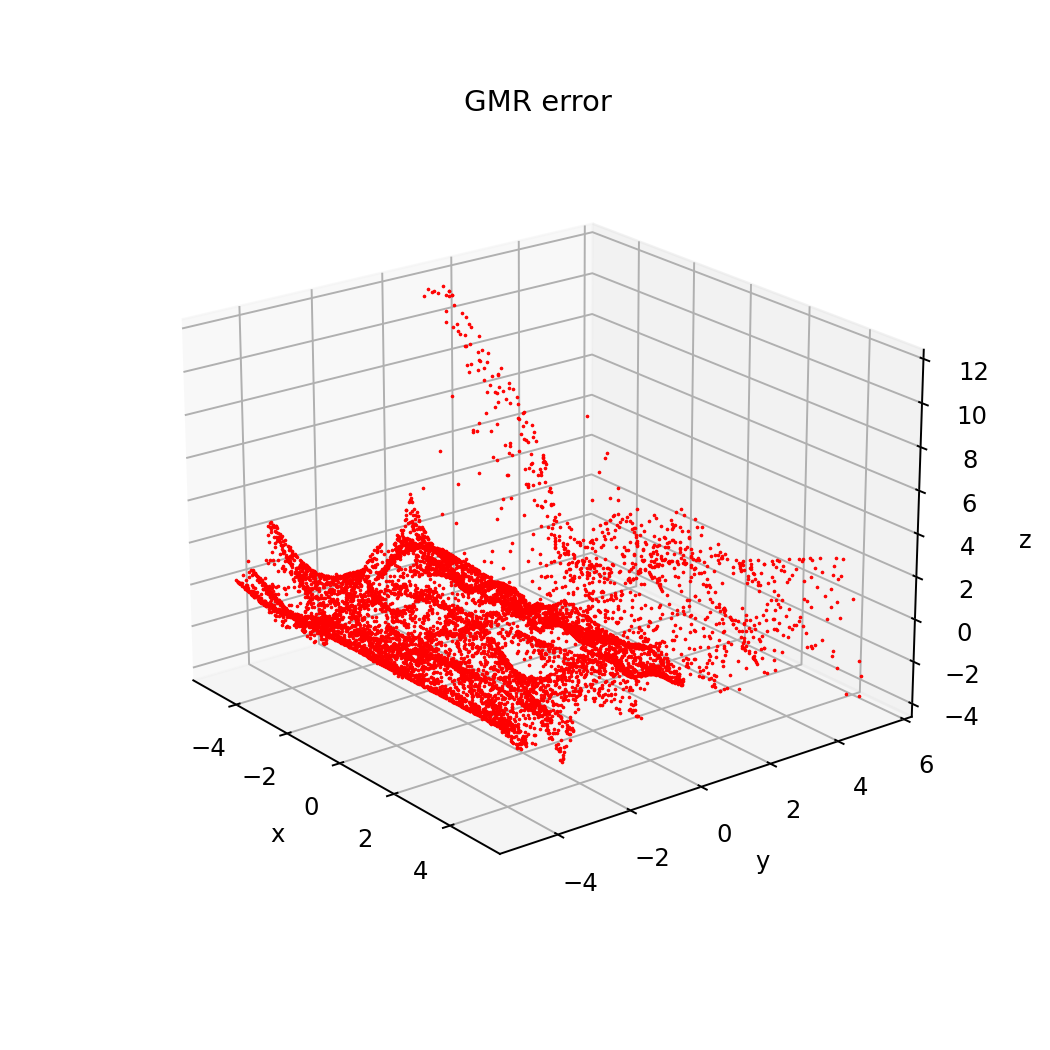

In [60]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(data[:,0],data[:,1],data[:,2]-mu[:,0],'r.',markersize=1.0)
#ax.plot(x_in[:,0],x_in[:,1],mu[:,0],'b.',markersize=.3)
ax.set_xlabel('torque')
ax.set_ylabel('angle')
ax.set_zlabel('acceleration')
ax.set_title('GMR error');

<p>still significant errors at the very end part of the range (particularly when x is near the lowest values), and there are not many y data. two thoughts: </p>     
    <li>Is there any way to specify the group center such that the end part regression becomes better. 
    <li> including the dependency in a different way? 
     
    dependency of the angle should be reflected only in the relationship between the torque and the acceleration (described in the following figure
    
    

<IPython.core.display.Javascript object>


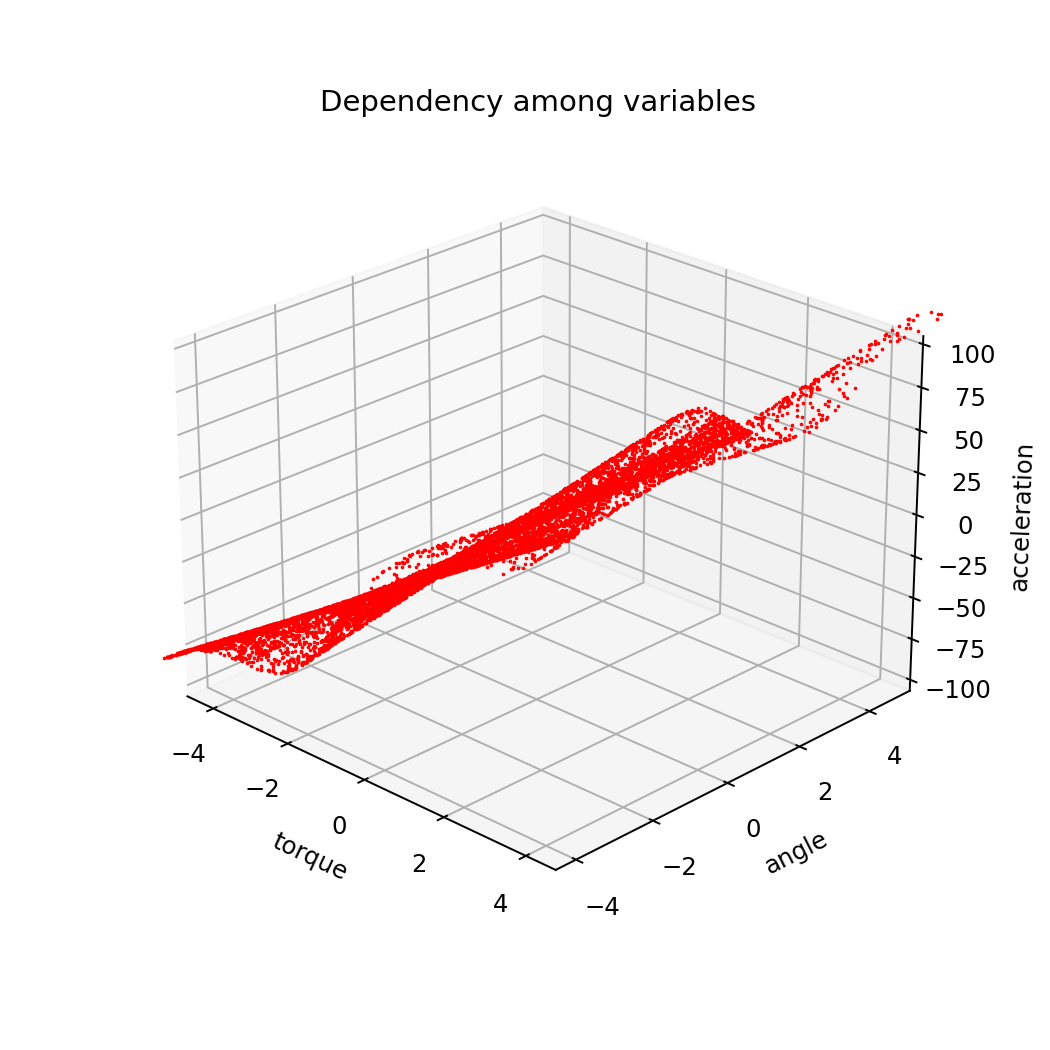

In [62]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(data[:,0],data[:,1],data[:,2],'r.',markersize=1.0)
ax.set_xlabel('torque')
ax.set_ylabel('angle')
ax.set_zlabel('acceleration')
ax.set_title('Dependency among variables');